In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd


In [22]:
bitcoin_hist = pd.read_csv("data/Bitcoin Historical Data - Investing.com.csv")
sp500_hist = pd.read_csv("data/S&P 500 Historical Data.csv")
dax_hist = pd.read_csv("data/DAX Historical Data.csv")
googl_hist = pd.read_csv("data/GOOGL Historical Data.csv")
trend_df = pd.read_csv("data/trends_bitcoin_cc_eth_trading_etf.csv")
bitcoin_sent_df = pd.read_csv("data/bitcoin_sentiments.csv")
economy_sent_df = pd.read_csv("data/economy_sentiments.csv")

In [23]:
def convert_values(row, col):
    val = row[col].replace(",","")
    return float(val)

def convert_vol(row, col):
    letter = row[col][-1]
    val = row[col].rstrip(letter)
    val = float(val)
    if letter=="M":
        val = val*1000000
    if letter=="K":
        val = val*1000
    
    return val

def prep_charts(df):
    df["Price"] = df.apply(convert_values, args=("Price",), axis=1)
    df["Open"] = df.apply(convert_values, args=("Open",), axis=1)
    df["High"] = df.apply(convert_values, args=("High",), axis=1)
    df["Low"] = df.apply(convert_values, args=("Low",), axis=1)

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date").reset_index()
    del df["index"]

    df["price_norm"] = df["Price"] / df["Price"].max()
    
    return df

In [24]:
bitcoin_hist = prep_charts(bitcoin_hist)
sp500_hist = prep_charts(sp500_hist)
dax_hist = prep_charts(dax_hist)
googl_hist = prep_charts(googl_hist)
bitcoin_hist["Vol."] = bitcoin_hist.apply(convert_vol, args=("Vol.",), axis=1)
bitcoin_hist["30_day_ma"] = bitcoin_hist["Price"].rolling(window=30, min_periods=1).mean()
bitcoin_hist["30_day_std"] = bitcoin_hist["Price"].rolling(window=30, min_periods=1).std()
bitcoin_hist["boll_upp"] = bitcoin_hist['30_day_ma'] + (bitcoin_hist['30_day_std'] * 2)
bitcoin_hist["boll_low"] = bitcoin_hist['30_day_ma'] - (bitcoin_hist['30_day_std'] * 2)


In [25]:
trend_df['date'] = pd.to_datetime(trend_df['date'])
trend_df = trend_df.set_index("date")
trend_df = trend_df.resample("D").sum()
trend_df.reset_index(inplace=True)


In [26]:
bitcoin_sent_df["date"] = pd.to_datetime(bitcoin_sent_df["date"])
bitcoin_sent_df["quot"] = bitcoin_sent_df["pos"] / bitcoin_sent_df["neg"]

In [27]:
economy_sent_df["date"] = pd.to_datetime(economy_sent_df["date"])
economy_sent_df["quot"] = economy_sent_df["pos"] / economy_sent_df["neg"]

In [31]:
corr_df = bitcoin_hist[["Date","Price", "High", "Low", "30_day_ma", "30_day_std", "boll_upp", "boll_low"]]
corr_df.columns = ["bitcoin_{}".format(x) for x in corr_df.columns]
corr_df.loc[:,"sp500_Price"] = sp500_hist["Price"]
corr_df.loc[:,"dax500_Price"] = dax_hist["Price"]
corr_df.loc[:,"google_Price"] = googl_hist["Price"]

corr_df = corr_df.merge(trend_df, left_on="bitcoin_Date", right_on="date").drop(columns=["date", "etf", "ethereum", "isPartial"])
corr_df = corr_df.rename(columns={"bitcoin":"bitcoin_Google_Trends", 
                                  "cryptocurrency":"cryptocurrency_Google_Trends",
                                  "trading":"trading_Google_Trends"})
corr_df = corr_df.merge(bitcoin_sent_df, left_on="bitcoin_Date", right_on="date").drop(columns=["date", "length"])
corr_df = corr_df.rename(columns={"pos": "bitcoin_pos_sents",
                                  "neg": "bitcoin_neg_sents",
                                  "quot": "bitcoin_quot_sents"})

In [32]:
corr_df = corr_df.merge(economy_sent_df, left_on="bitcoin_Date", right_on="date").drop(columns=["date", "length"])
corr_df = corr_df.rename(columns={"pos": "economy_pos_sents",
                                  "neg": "economy_neg_sents",
                                  "quot": "economy_quot_sents"})

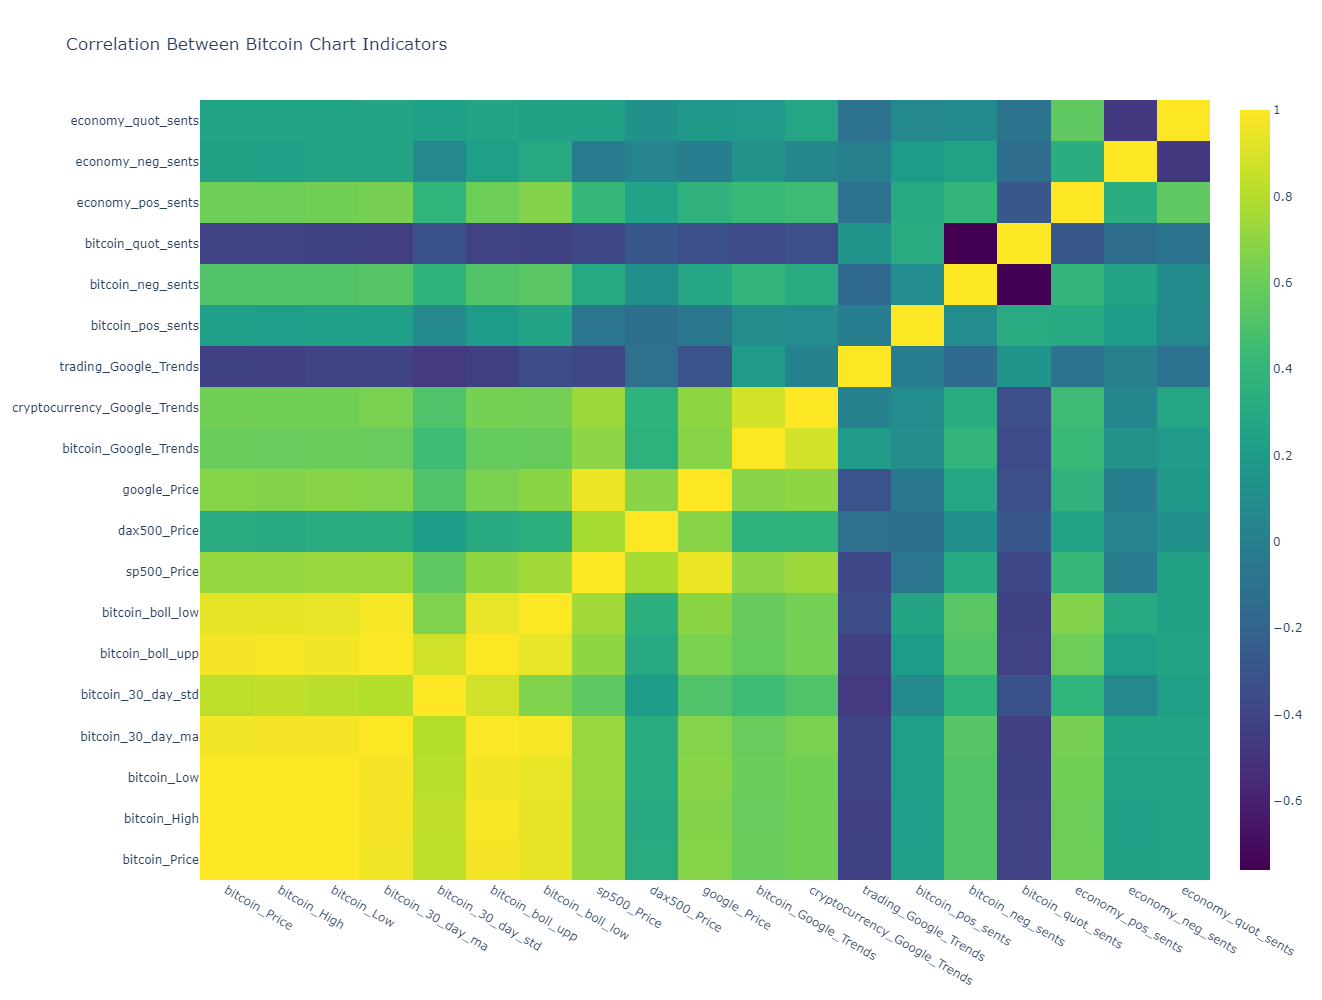

In [44]:
corr = corr_df.corr()
coordinates = corr.values.tolist()
columns = list(corr.columns)

trace1 = {
        "type": "heatmap", 
        "x": columns, 
        "y": columns, 
        "z": coordinates,
        "colorscale": 'viridis'
        }
    
data = trace1
layout = {"title": "Correlation Between Bitcoin Chart Indicators",
          "width": 1200,
          "height": 1000}
fig = go.Figure(dict(data=data, layout=layout))
fig.show()

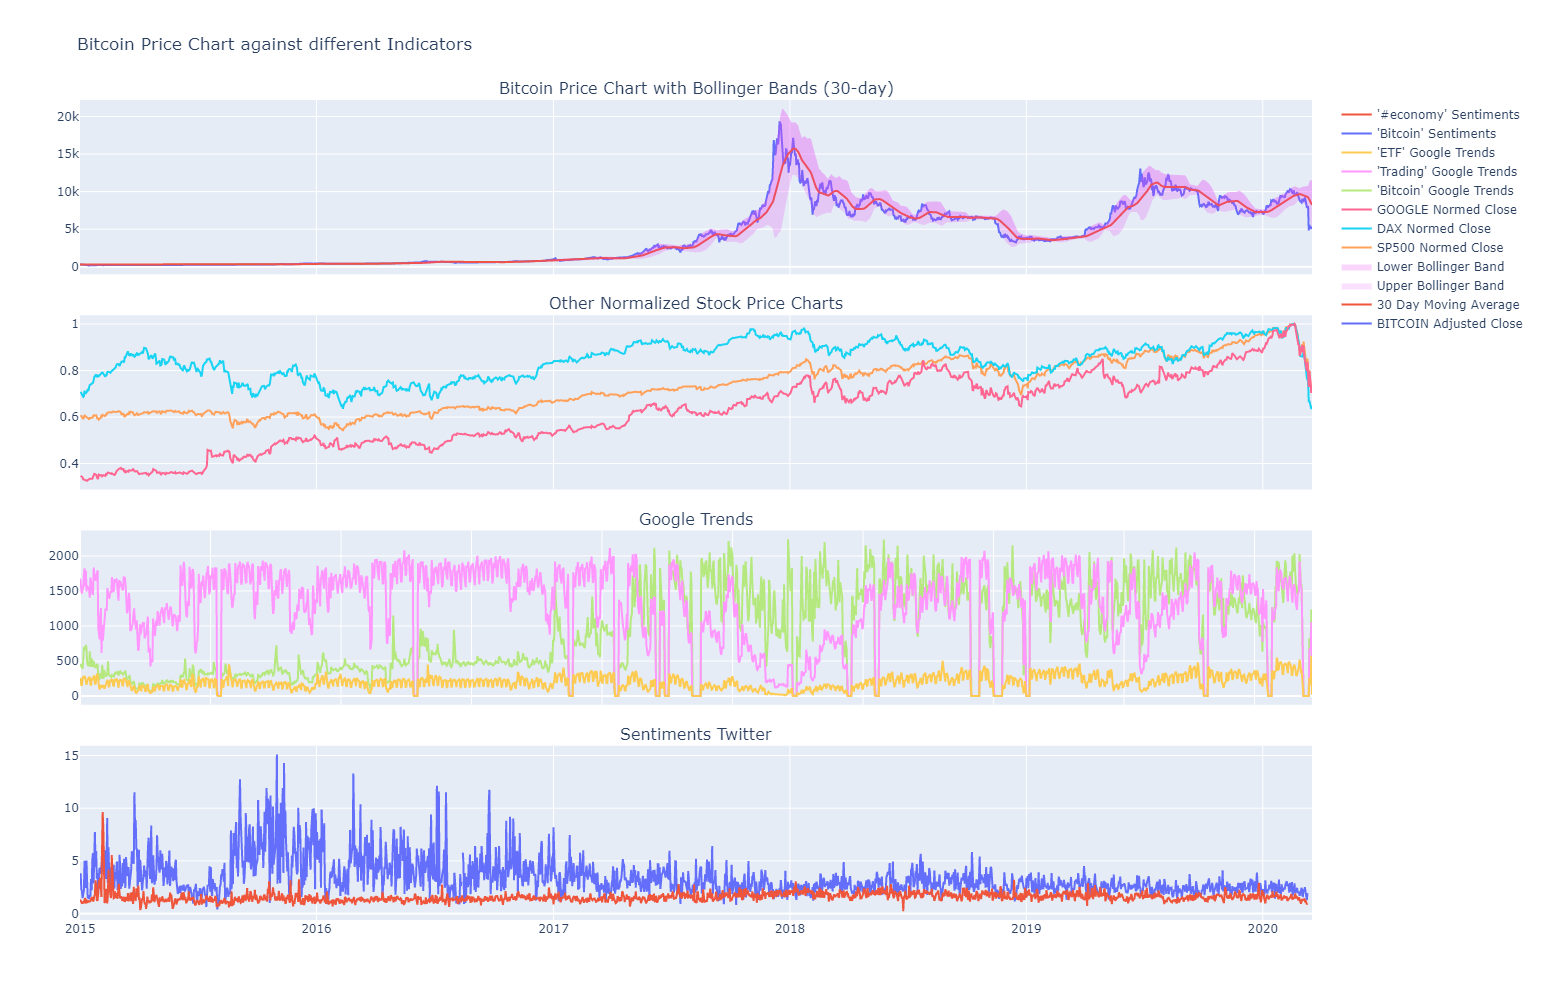

In [48]:
fig = make_subplots(
    rows=4, 
    cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.05,
    subplot_titles=("Bitcoin Price Chart with Bollinger Bands (30-day)", 
                    "Other Normalized Stock Price Charts", 
                    "Google Trends", 
                    "Sentiments Twitter")
)

#fig = go.Figure()

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['Price'],
                         name="BITCOIN Adjusted Close"), row=1, col=1)

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['30_day_ma'],
                         name="30 Day Moving Average"), row=1, col=1)

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['boll_upp'],
                         fill='tonexty',
                         fillcolor='rgba(231,107,243,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name="Upper Bollinger Band"), row=1, col=1)

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['boll_low'],
                         fill='tonexty',
                         fillcolor='rgba(231,50,243,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name="Lower Bollinger Band"), row=1, col=1)


fig.add_trace(go.Scatter(x=sp500_hist['Date'], 
                         y=sp500_hist['price_norm'],
                         name="SP500 Normed Close"), row=2, col=1)

fig.add_trace(go.Scatter(x=dax_hist['Date'], 
                         y=dax_hist['price_norm'],
                         name="DAX Normed Close"), row=2, col=1)


fig.add_trace(go.Scatter(x=googl_hist['Date'], 
                         y=googl_hist['price_norm'],
                         name="GOOGLE Normed Close"), row=2, col=1)


fig.add_trace(go.Scatter(x=trend_df.index,
                         y=trend_df["bitcoin"],
                         name="'Bitcoin' Google Trends"), row=3, col=1)

fig.add_trace(go.Scatter(x=trend_df.index,
                         y=trend_df["trading"],
                         name="'Trading' Google Trends"), row=3, col=1)

fig.add_trace(go.Scatter(x=trend_df.index,
                         y=trend_df["etf"],
                         name="'ETF' Google Trends"), row=3, col=1)

fig.add_trace(go.Scatter(x=bitcoin_sent_df["date"],
                         y=bitcoin_sent_df["quot"],
                         name="'Bitcoin' Sentiments"), row=4, col=1)

fig.add_trace(go.Scatter(x=economy_sent_df["date"],
                         y=economy_sent_df["quot"],
                         name="'#economy' Sentiments"), row=4, col=1)


fig.update_layout(height=1000, width=1500, title_text="Bitcoin Price Chart against different Indicators")

fig.show()